In [1]:
from pyspark.sql import SparkSession

In [2]:
spark = SparkSession.builder.appName('pyspark-training-spark-ml').master('local[2]').getOrCreate()

### https://www.kaggle.com/c/avazu-ctr-prediction/data

### model

##### id: ad identifier
##### click: 0/1 for non-click/click
##### hour: format is YYMMDDHH, so 14091123 means 23:00 on Sept. 11, 2014 UTC.
##### C1 -- anonymized categorical variable
##### banner_pos
##### site_id
##### site_domain
##### site_category
##### app_id
##### app_domain
##### app_category
##### device_id
##### device_ip
##### device_model
##### device_type
##### device_conn_type
##### C14-C21 -- anonymized categorical variables

In [45]:
df = spark.read.parquet('D:\\data\\click-through-kaggle-train-pqt')

### Analyze data

In [46]:
df.printSchema()

root
 |-- id: decimal(20,0) (nullable = true)
 |-- click: integer (nullable = true)
 |-- hour: integer (nullable = true)
 |-- C1: integer (nullable = true)
 |-- banner_pos: integer (nullable = true)
 |-- site_id: string (nullable = true)
 |-- site_domain: string (nullable = true)
 |-- site_category: string (nullable = true)
 |-- app_id: string (nullable = true)
 |-- app_domain: string (nullable = true)
 |-- app_category: string (nullable = true)
 |-- device_id: string (nullable = true)
 |-- device_ip: string (nullable = true)
 |-- device_model: string (nullable = true)
 |-- device_type: integer (nullable = true)
 |-- device_conn_type: integer (nullable = true)
 |-- C14: integer (nullable = true)
 |-- C15: integer (nullable = true)
 |-- C16: integer (nullable = true)
 |-- C17: integer (nullable = true)
 |-- C18: integer (nullable = true)
 |-- C19: integer (nullable = true)
 |-- C20: integer (nullable = true)
 |-- C21: integer (nullable = true)



In [47]:
df.count()

500000

In [48]:
df.columns

['id',
 'click',
 'hour',
 'C1',
 'banner_pos',
 'site_id',
 'site_domain',
 'site_category',
 'app_id',
 'app_domain',
 'app_category',
 'device_id',
 'device_ip',
 'device_model',
 'device_type',
 'device_conn_type',
 'C14',
 'C15',
 'C16',
 'C17',
 'C18',
 'C19',
 'C20',
 'C21']

In [49]:
for col in df.columns:
    print(col, df.select(col).distinct().count())

id 500000
click 2
hour 4
C1 6
banner_pos 6
site_id 1707
site_domain 1832
site_category 16
app_id 1388
app_domain 90
app_category 21
device_id 71136
device_ip 197968
device_model 3933
device_type 4
device_conn_type 4
C14 847
C15 8
C16 9
C17 177
C18 4
C19 41
C20 157
C21 32


### Feature engineering

In [103]:
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.feature import StandardScaler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

#### one hot encoding of categorical variables

In [51]:
categorical_columns = ['banner_pos', 'device_type', 'device_conn_type', 'app_category', 'site_category']

In [52]:
stages = []
indexers = [
     StringIndexer(inputCol=c, outputCol='{0}_indexed'.format(c))
     for c in categorical_columns
   ]
input_cols = [indexer.getOutputCol() for indexer in indexers]
output_cols = ['{}_encoded'.format(indexer.getOutputCol()) for indexer in indexers]
encoders = OneHotEncoder(inputCols=input_cols, outputCols=output_cols)
stages += indexers
stages += [encoders]

#### label indexing

In [53]:
label_indexer = StringIndexer(inputCol="click", outputCol="label")
stages += [label_indexer]

In [54]:
other_columns = ['id', 'site_id', 'site_domain', 'app_id', 'app_domain', 'device_id', 'device_ip', 'device_model', 'click']
all_columns = df.columns
numeric_columns = list(set(all_columns) - set(categorical_columns) - set(other_columns))

In [55]:
numeric_columns

['C16', 'C14', 'C15', 'hour', 'C1', 'C19', 'C20', 'C17', 'C21', 'C18']

#### assembling all the features using a vector assembler

In [56]:
assembler_input_cols = encoders.getOutputCols() + numeric_columns
assembler = VectorAssembler(inputCols=assembler_input_cols, outputCol="vectorized_features")
stages += [assembler]

#### creating a pipeline to perform all the stages

In [57]:
pipeline = Pipeline().setStages(stages)
assembled = pipeline.fit(df)
df_assembled = assembled.transform(df)

In [58]:
df_vectorized = df_assembled.select('id', 'vectorized_features', 'label')

#### scaling the data with the help of a StandardScaler

In [59]:
scaler = StandardScaler(inputCol="vectorized_features", outputCol="features",
                        withStd=True, withMean=False)

In [60]:
scaler_model = scaler.fit(df_vectorized)

In [61]:
df_scaled = scaler_model.transform(df_vectorized).drop('vectorized_features')

In [62]:
df_scaled.show()

+--------------------+-----+--------------------+
|                  id|label|            features|
+--------------------+-----+--------------------+
|13438938916556439466|  1.0|(56,[1,5,8,11,32,...|
|13439050860308297569|  0.0|(56,[0,5,8,12,31,...|
| 1343908897585470171|  0.0|(56,[0,5,8,12,31,...|
|13439188275655738522|  0.0|(56,[1,5,8,11,32,...|
|13439191819288197832|  0.0|(56,[0,5,10,12,31...|
|13439344692531313628|  0.0|(56,[0,5,8,11,33,...|
|13439371205014005161|  0.0|(56,[1,5,9,12,31,...|
|13439486992814922112|  1.0|(56,[0,6,8,11,31,...|
|13439709364885762232|  0.0|(56,[0,6,8,11,31,...|
| 1343972248019343137|  0.0|(56,[0,5,8,11,33,...|
| 1343972590469623013|  0.0|(56,[0,5,8,11,34,...|
|13439744874038142235|  0.0|(56,[1,5,8,11,34,...|
|13440085559813320362|  1.0|(56,[0,5,8,12,31,...|
|13440086428653076955|  0.0|(56,[0,5,10,12,31...|
|13440232523560932451|  0.0|(56,[0,5,9,11,31,...|
|13440239267259348683|  0.0|(56,[0,5,8,11,33,...|
|13440313598253076349|  0.0|(56,[0,5,9,14,31,...|


In [94]:
df_train, df_test = df_scaled.randomSplit([0.7, 0.3], seed=42)

### Building the model

In [89]:
def feature_engineering(df):
    categorical_columns = ['banner_pos', 'device_type', 'device_conn_type', 'app_category', 'site_category']
    
    stages = []
    indexers = [
         StringIndexer(inputCol=c, outputCol='{0}_indexed'.format(c))
         for c in categorical_columns
       ]
    input_cols = [indexer.getOutputCol() for indexer in indexers]
    output_cols = ['{}_encoded'.format(indexer.getOutputCol()) for indexer in indexers]
    encoders = OneHotEncoder(inputCols=input_cols, outputCols=output_cols)
    stages += indexers
    stages += [encoders]
    label_indexer = StringIndexer(inputCol="click", outputCol="label")
    stages += [label_indexer]
    other_columns = ['id', 'site_id', 'site_domain', 'app_id', 'app_domain', 'device_id', 'device_ip', 'device_model', 'click']
    all_columns = df.columns
    numeric_columns = list(set(all_columns) - set(categorical_columns) - set(other_columns))
    assembler_input_cols = encoders.getOutputCols() + numeric_columns
    assembler = VectorAssembler(inputCols=assembler_input_cols, outputCol="vectorized_features")
    stages += [assembler]
    pipeline = Pipeline().setStages(stages)
    assembled = pipeline.fit(df)
    df_assembled = assembled.transform(df)
    df_vectorized = df_assembled.select('id', 'vectorized_features', 'label')
    scaler = StandardScaler(inputCol="vectorized_features", outputCol="features",
                            withStd=True, withMean=False)
    scaler_model = scaler.fit(df_vectorized)
    df_scaled = scaler_model.transform(df_vectorized).drop('vectorized_features')
    return df_scaled

#### GBT

##### train

In [63]:
from pyspark.ml.classification import GBTClassifier

In [64]:
gbt = GBTClassifier(labelCol="label", featuresCol="features", maxIter=10)

In [95]:
model_gbt = gbt.fit(df_train)

In [96]:
df_test_pred = model_gbt.transform(df_test)

In [101]:
df_test_pred.groupBy('prediction').count().show()

+----------+------+
|prediction| count|
+----------+------+
|       0.0|149366|
|       1.0|   769|
+----------+------+



In [100]:
df_test_pred.select('id', 'label', 'probability', 'prediction').show(20, False)

+----------------+-----+----------------------------------------+----------+
|id              |label|probability                             |prediction|
+----------------+-----+----------------------------------------+----------+
|129263355726160 |0.0  |[0.8655697051338427,0.13443029486615732]|0.0       |
|337879153775332 |0.0  |[0.9026415181790906,0.09735848182090945]|0.0       |
|437068175922770 |0.0  |[0.8443882247188244,0.15561177528117565]|0.0       |
|438702421250968 |0.0  |[0.8874772008275934,0.1125227991724066] |0.0       |
|522487037763823 |0.0  |[0.8610261187487995,0.13897388125120047]|0.0       |
|585076171034385 |1.0  |[0.8474663468791906,0.15253365312080935]|0.0       |
|772199976867910 |0.0  |[0.8389047930619687,0.16109520693803125]|0.0       |
|945082610781181 |0.0  |[0.8389047930619687,0.16109520693803125]|0.0       |
|1073435849427196|0.0  |[0.8680747237275492,0.13192527627245076]|0.0       |
|1200142667419110|0.0  |[0.8655697051338427,0.13443029486615732]|0.0       |

In [165]:
df_test_pred

DataFrame[id: decimal(20,0), label: double, features: vector, rawPrediction: vector, probability: vector, prediction: double]

In [166]:
from pyspark.ml.functions import vector_to_array

In [162]:
import pyspark.sql.functions as f

In [186]:
df_test_pred_f = df_test_pred.withColumn('probability', vector_to_array('probability'))\
                   .withColumn('pred_proba', f.when(f.col('probability')[1] > 0.3, 1.0).otherwise(0.0))

In [187]:
df_test_pred_f

DataFrame[id: decimal(20,0), label: double, features: vector, rawPrediction: vector, probability: array<double>, prediction: double, pred_proba: double]

In [188]:
df_test_pred_f.select('id', 'label', 'probability', 'pred_proba').show(20, False)

+----------------+-----+-----------------------------------------+----------+
|id              |label|probability                              |pred_proba|
+----------------+-----+-----------------------------------------+----------+
|129263355726160 |0.0  |[0.8655697051338427, 0.13443029486615732]|0.0       |
|337879153775332 |0.0  |[0.9026415181790906, 0.09735848182090945]|0.0       |
|437068175922770 |0.0  |[0.8443882247188244, 0.15561177528117565]|0.0       |
|438702421250968 |0.0  |[0.8874772008275934, 0.1125227991724066] |0.0       |
|522487037763823 |0.0  |[0.8610261187487995, 0.13897388125120047]|0.0       |
|585076171034385 |1.0  |[0.8474663468791906, 0.15253365312080935]|0.0       |
|772199976867910 |0.0  |[0.8389047930619687, 0.16109520693803125]|0.0       |
|945082610781181 |0.0  |[0.8389047930619687, 0.16109520693803125]|0.0       |
|1073435849427196|0.0  |[0.8680747237275492, 0.13192527627245076]|0.0       |
|1200142667419110|0.0  |[0.8655697051338427, 0.13443029486615732

# Confusion matrix

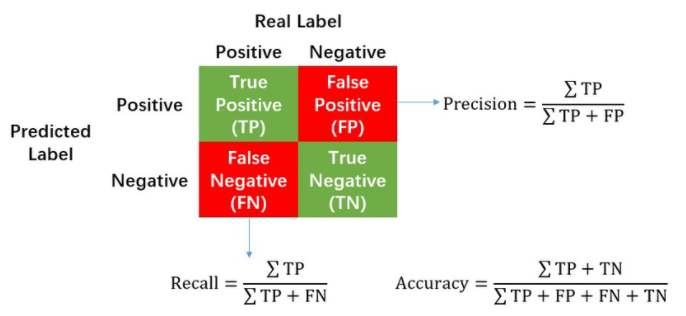

In [189]:
from pyspark.mllib.evaluation import MulticlassMetrics

In [190]:
rdd_pred_label = df_test_pred_f.select('pred_proba', 'label').rdd

In [191]:
metrics = MulticlassMetrics(rdd_pred_label)

In [192]:
metrics.accuracy

0.8242781496653012

In [196]:
metrics.confusionMatrix().toArray()

array([[119225.,   7602.],
       [ 18780.,   4528.]])

In [201]:
metrics.precision(0)

0.8639179739864498

In [200]:
metrics.recall(0)

0.9400600818437714

#### Random Forest

In [67]:
from pyspark.ml.classification import RandomForestClassifier

In [68]:
rf = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=10)

In [204]:
model_rf = rf.fit(df_train)

In [205]:
df_test_pred = model_rf.transform(df_test)

In [207]:
df_test_pred_f = df_test_pred.withColumn('probability', vector_to_array('probability'))\
                   .withColumn('pred_proba', f.when(f.col('probability')[1] > 0.3, 1.0).otherwise(0.0))

In [208]:
rdd_pred_label = df_test_pred_f.select('pred_proba', 'label').rdd

In [209]:
metrics = MulticlassMetrics(rdd_pred_label)

c:\users\mohit\appdata\local\programs\python\python37\lib\site-packages\pyspark\sql\context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


In [210]:
metrics.accuracy

0.8467579178739135

In [211]:
metrics.confusionMatrix().toArray()

array([[126582.,    245.],
       [ 22762.,    546.]])

In [212]:
metrics.precision(0)

0.8475867795157489

In [213]:
metrics.recall(0)

0.9980682346818895

#### Decision Tree

In [71]:
from pyspark.ml.classification import DecisionTreeClassifier

In [72]:
dt = DecisionTreeClassifier(labelCol="label", featuresCol="features")

In [215]:
model_dt = dt.fit(df_train)

In [216]:
df_test_pred = model_dt.transform(df_test)

In [217]:
df_test_pred_f = df_test_pred.withColumn('probability', vector_to_array('probability'))\
                   .withColumn('pred_proba', f.when(f.col('probability')[1] > 0.3, 1.0).otherwise(0.0))

In [218]:
rdd_pred_label = df_test_pred_f.select('pred_proba', 'label').rdd

In [219]:
metrics = MulticlassMetrics(rdd_pred_label)

In [220]:
metrics.accuracy

0.8407233489859127

In [221]:
metrics.confusionMatrix().toArray()

array([[124151.,   2676.],
       [ 21237.,   2071.]])

In [222]:
metrics.precision(0)

0.8539287974248219

In [223]:
metrics.recall(0)

0.9789003918723931

#### Logistic Regression

In [75]:
from pyspark.ml.classification import LogisticRegression

In [76]:
lr = LogisticRegression(labelCol="label", featuresCol="features", maxIter=10, regParam=0.3, elasticNetParam=0.8)

In [224]:
model_lr = lr.fit(df_train)

In [233]:
df_test_pred = model_lr.transform(df_test)

In [234]:
df_test_pred_f = df_test_pred.withColumn('probability', vector_to_array('probability'))\
                   .withColumn('pred_proba', f.when(f.col('probability')[1] > 0.3, 1.0).otherwise(0.0))

In [235]:
rdd_pred_label = df_test_pred_f.select('pred_proba', 'label').rdd

In [236]:
metrics = MulticlassMetrics(rdd_pred_label)

In [237]:
metrics.accuracy

0.8447530555833084

In [238]:
metrics.confusionMatrix().toArray()

array([[126827.,      0.],
       [ 23308.,      0.]])

In [239]:
metrics.precision(0)

0.8447530555833084

In [240]:
metrics.recall(0)

1.0